In [1]:
import random

import pydicom as dicom
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import scipy.ndimage
from exercises_code import *
import glob


In [2]:
%load_ext autoreload
%autoreload 2

# Task 1

Load up the data first

In [3]:
# let's load up reference dcm
ref_dcm = dicom.read_file('./p2data/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm')
ref_block = ref_dcm.pixel_array

# currently, let's assume the input data is as nice as previous part
# ask Pedro if it's alright to assume that 
input_glob = './p2data/RM_Brain_3D-SPGR/00*.dcm'
input_files = glob.glob(input_glob)
input_dcms = [
    dicom.dcmread(f) for f in input_files
]
# we are doing alot of assumption that Slice location exists
# and that the data is as nice as the pervious part
slice_to_pixel = {
    input_dcm.ImagePositionPatient[2] : input_dcm.pixel_array for input_dcm in input_dcms
}
input_block = np.array(
    [
        slice_to_pixel[k] for k in sorted(slice_to_pixel.keys())
    ]
)
assert len(input_dcms) == len(slice_to_pixel.keys()), "Slice location different from input files! Repeated Slice Location!"
print("input block shape:", input_block.shape)
print("reference block shape:", ref_dcm.pixel_array.shape)
# let's get aspect ratio first
slice_thickness = input_dcms[0].SliceThickness # I think it's all the same for all slice if it follows part1 style 
pixel_spacing = input_dcms[0].PixelSpacing # I think it's all the same for all slice if it follows part1 style 
print('Slice Thickness', slice_thickness)
print('Pixel Spacing', pixel_spacing)
pixel_len_mm = [float(input_dcms[0].SliceThickness),
                input_dcms[0].PixelSpacing[0],
                input_dcms[0].PixelSpacing[1]]
aspect_ratio = pixel_len_mm[0] / pixel_len_mm[1]


input block shape: (212, 512, 512)
reference block shape: (193, 229, 193)
Slice Thickness 2
Pixel Spacing [0.5078, 0.5078]


### Rotate and Edit Image for better initialization

Here we plot to see if they match (they don't, the orientation is not the same)

Then we perform some rotations and zoom (to match slice thickness and pixel spacing) to get better first initialization for co registration

In [4]:
def plot_image_and_reference_comparison(
        image_block: np.array,
        reference_block: np.array,
        img_aspect: float = 1.0/pixel_spacing[0],
        ref_aspect = None):
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(median_axial_plane(image_block), cmap='bone')
    plt.title("Input Axial")

    plt.subplot(2, 3, 2)
    plt.imshow(median_coronal_plane(image_block), cmap='bone', aspect=img_aspect)
    plt.title("Input Coronal")

    plt.subplot(2, 3, 3)
    plt.imshow(median_sagittal_plane(image_block), cmap='bone', aspect=img_aspect)
    plt.title("Input Sagittal")

    plt.subplot(2, 3, 4)
    plt.imshow(median_axial_plane(reference_block), cmap='bone')
    plt.title("Reference Axial")

    plt.subplot(2, 3, 5)
    plt.imshow(median_coronal_plane(reference_block), cmap='bone', aspect=ref_aspect)
    plt.title("Reference Coronal")

    plt.subplot(2, 3, 6)
    plt.imshow(median_sagittal_plane(reference_block), cmap='bone', aspect=ref_aspect)
    plt.title("Reference Sagittal")

    plt.show()
    

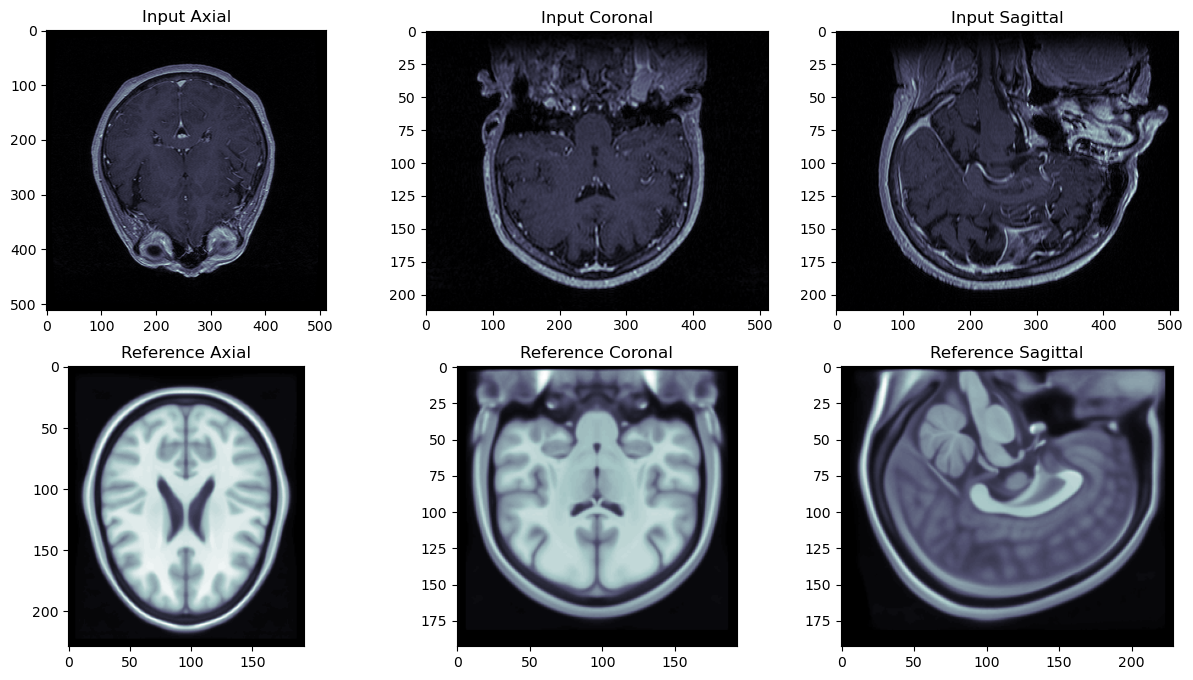

In [5]:
rot_block = input_block.copy()
rot_block = rotate_on_axial_plane(rot_block, 180)
plot_image_and_reference_comparison(image_block=rot_block, reference_block=ref_block, img_aspect=1/pixel_spacing[0])

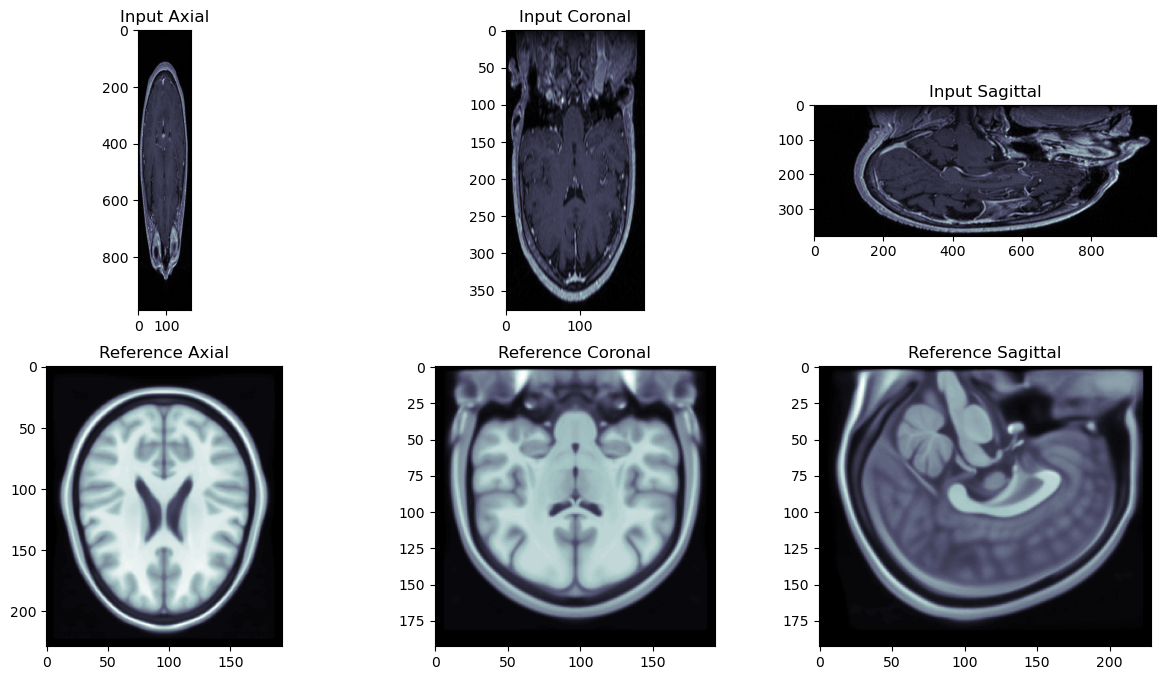

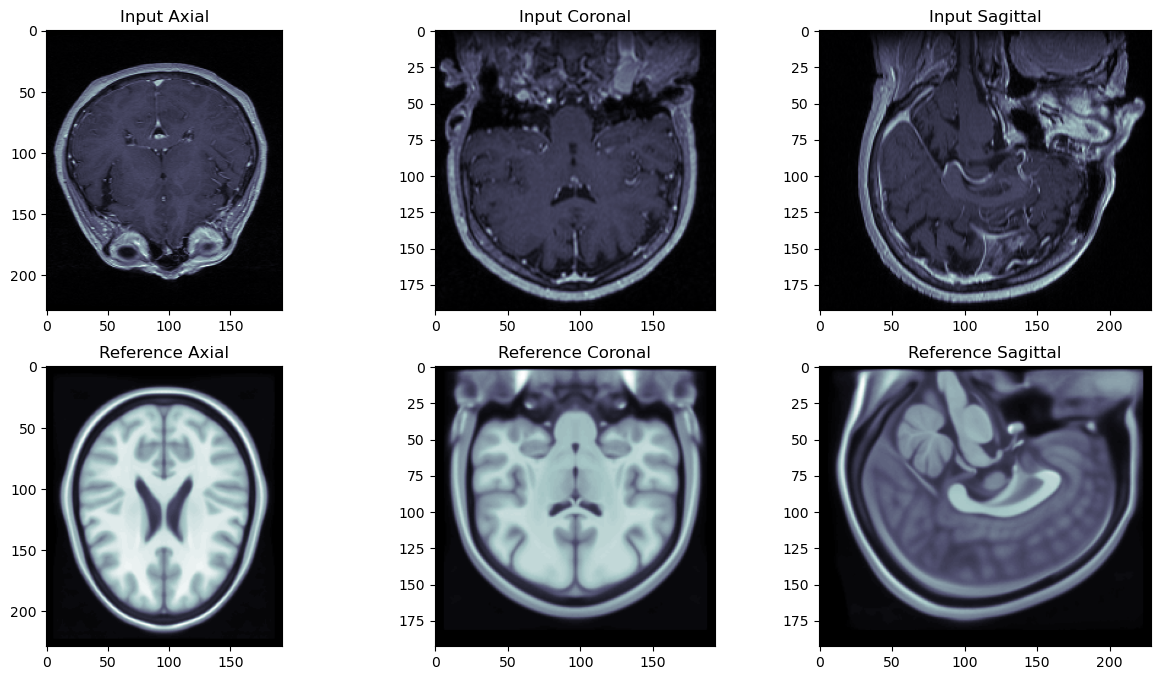

In [6]:
# Firstly, we perform zoom with zoom factor of pixel_spacing and slice thickness to bring the voxel scale factor to 1 1 1 
# Then we cropped it such that we can have an image closer to the reference 
# Then we zoom to the dimension of the reference
# This way we get input data closer to the reference.
zoom_factors = [
    1/pixel_spacing[0],
    1/pixel_spacing[1],
    1/slice_thickness
]

# Apply zoom
zoomed_input = scipy.ndimage.zoom(rot_block, zoom_factors, order=1)


zoomed_input = zoomed_input[
                       20:zoomed_input.shape[0]-20,
                       10:zoomed_input.shape[1]-10, 
                       35:zoomed_input.shape[2]-35]

# Visualization
plot_image_and_reference_comparison(
    image_block=zoomed_input,
    reference_block=ref_block,
    img_aspect=1.0,
    ref_aspect=1.0
)

# 
zoom_factors = [
    ref_block.shape[0]/zoomed_input.shape[0],
    ref_block.shape[1]/zoomed_input.shape[1],
    ref_block.shape[2]/zoomed_input.shape[2],
]
# 
zoomed_input = scipy.ndimage.zoom(zoomed_input, zoom_factors, order=1)

# Visualization
plot_image_and_reference_comparison(
    image_block=zoomed_input,
    reference_block=ref_block,
    img_aspect=1.0,
    ref_aspect=1.0
)


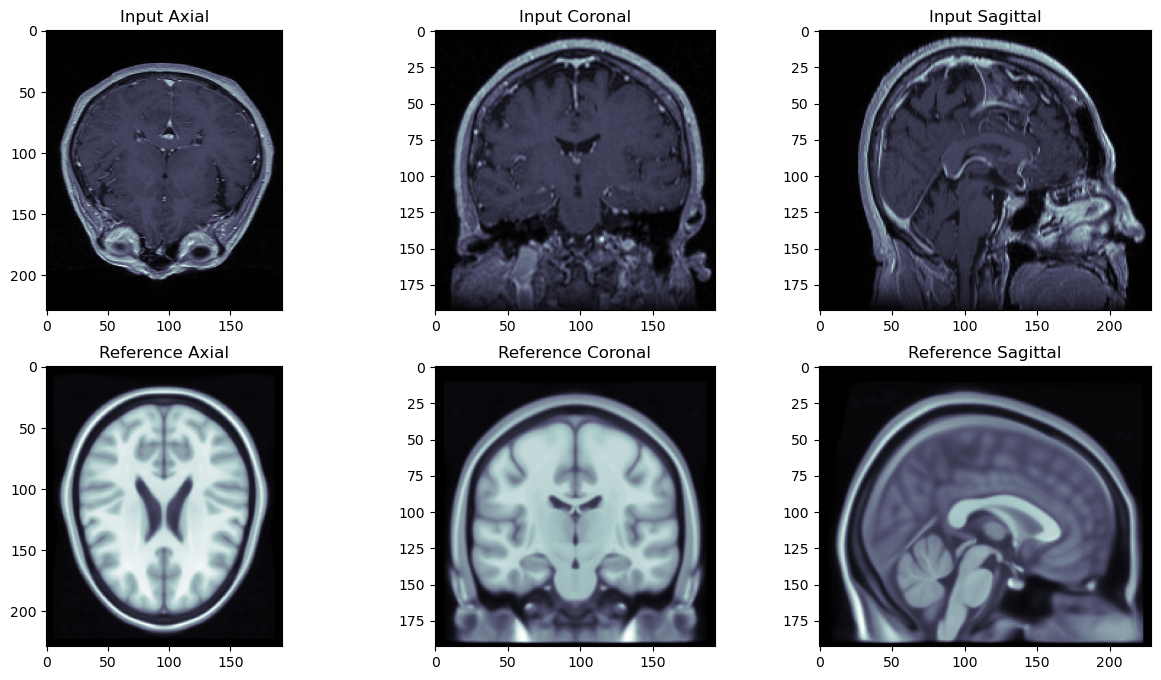

In [7]:
rotated_zoomed_input = scipy.ndimage.rotate(zoomed_input.copy(), 180, axes=(0, 2), reshape=False, mode='nearest', order=0)
rotated_ref_block = scipy.ndimage.rotate(ref_block.copy(), 180, axes=(0, 2), reshape=False, mode='nearest', order=0)
plot_image_and_reference_comparison(image_block=rotated_zoomed_input, reference_block=rotated_ref_block, img_aspect=1)

### Co Registration

we have implemented co registration here.


In [48]:
import numpy as np
import scipy.ndimage
import scipy.optimize
import random

def to_degree(angle):
    return angle * 180/np.pi

def find_centroid_block(block):
    # cant use find_centroid cus it's == 1
    idcs = np.where(block != 0)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def transform_block(params, original_block):
    """
    Apply translation and rotation to the reference block.
    params: [trans_x, trans_y, trans_z, angle_x, angle_y, angle_z]
    reference_block: 3D numpy array (the reference image block)
    """
    trans_x, trans_y, trans_z, angle_x, angle_y, angle_z = params

    # Apply translation
    translated = np.roll(original_block, 
                         np.array(params[:3]).astype(int), 
                         axis=(0, 1, 2))

    # Apply rotation
    # angles are in radian convert to degree
    rotated = scipy.ndimage.rotate(translated, to_degree(angle_x), axes=(1, 2), reshape=False)
    rotated = scipy.ndimage.rotate(rotated, to_degree(angle_y), axes=(0, 2), reshape=False)
    rotated = scipy.ndimage.rotate(rotated, to_degree(angle_z), axes=(0, 1), reshape=False)

    return rotated

def constant_pi():
    return [np.pi, np.pi, np.pi]

def uniform():
    return [random.uniform(0, 0.05),
            random.uniform(0, 0.05), 
            random.uniform(0, 0.05)]
    
def ssd(b1, b2):
    return np.mean((b1 - b2)**2)

def mae(b1, b2):
    return np.mean(np.abs(b1 - b2))

def coregister_image(
        image_block,
        reference_block,
        generate_param_angle,
        cost_func,
        optimize_method):
    centroid_img = find_centroid_block(image_block)
    centroid_ref = find_centroid_block(reference_block)

    translation_vector = centroid_img - centroid_ref
    initial_parameters = [
        0, 0, 0,    # Translation vector
        0.1, 0.1, .1     #
    ]
    initial_parameters[0] = translation_vector[0]
    initial_parameters[1] = translation_vector[1]
    initial_parameters[2] = translation_vector[2]
    initial_angles = generate_param_angle()
    initial_parameters[3] = initial_angles[0]
    initial_parameters[4] = initial_angles[1]
    initial_parameters[5] = initial_angles[2]
    errors = [] # check if optimizing

    def loss_function(params):
        transformed_block = transform_block(params, image_block)
        err = cost_func(reference_block, transformed_block)
        errors.append(err)
        return err

    # Run optimization
    # One of optimize scipy defined outside 
    result = optimize_method(loss_function, x0=initial_parameters)
    resulting_block = transform_block(result.x, image_block)
    return resulting_block, result, errors

def normalize(block):
    # need to do 3d normalization 
    min_val, max_val = np.min(block), np.max(block)
    return (block - min_val)/(max_val - min_val)


BOUNDS = ((-ref_block.shape[0], ref_block.shape[0]),
          (-ref_block.shape[1], ref_block.shape[1]),
          (-ref_block.shape[2], ref_block.shape[2]),
          (-2*np.pi, 2*np.pi),
          (-2*np.pi, 2*np.pi),
          (-2*np.pi, 2*np.pi))

def optimize_with_method(method):
    method = method
    def noptimize(loss_function, x0):
        return scipy.optimize.minimize(
            loss_function,
            x0 = x0,
            method=method,
            bounds=BOUNDS
        )
    def nleast_squares(loss_function, x0):
        return scipy.optimize.least_squares(
            loss_function,
            x0 = x0,
        )
    def basinhopping(loss_function, x0):
        return scipy.optimize.basinhopping(
            loss_function,
            x0 = x0,
            minimizer_kwargs = {"method": "BFGS"}
        )
    if method == 'least_squares':
        return nleast_squares
    elif method == 'basinhopping':
        return basinhopping
    return noptimize

In [49]:
angle_methods = {
    "uniform": uniform,
    "pi": constant_pi
}
cost_funcs = {
    "ssd": ssd,
    "mae": mae
}

optimize = {
    "minimize": optimize_with_method(None),
    "least_squares": optimize_with_method('least_squares'),
    "BFGS": optimize_with_method("BFGS"),
    'basinhopping': optimize_with_method('basinhopping')
}

In [50]:
norm_input = normalize(rotated_zoomed_input)
norm_ref = normalize(rotated_ref_block)
results = []

In [51]:
# Testing if the algorithm works by using zoomed input instead of its final rotation one
# for i in range(10):
final_block_bfgs, result_bfgs, errors_bfgs = coregister_image(
    norm_input,
    norm_ref, 
    uniform,
    ssd,
    optimize['BFGS'])

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_81237/2381559117.py:105: RuntimeWarning: Method BFGS cannot handle bounds.
  return scipy.optimize.minimize(


In [52]:
print("resuling errors:", errors_bfgs)
print("resulting transformation parameters:", result_bfgs.x)


resuling errors: [0.05349500479506326, 0.05349500479506326, 0.05349500479506326, 0.05349500479506326, 0.053495004825947275, 0.05349500487800018, 0.05349500476130525, 0.05345877926807633, 0.05345877926807633, 0.05345877926807633, 0.05345877926807633, 0.05345877925804879, 0.05345877934246279, 0.053458779238892015, 0.05339529125662036, 0.05339529125662036, 0.05339529125662036, 0.05339529125662036, 0.05339529122344902, 0.05339529131075841, 0.053395291235493615, 0.05332626461082965, 0.05332626461082965, 0.05332626461082965, 0.05332626461082965, 0.05332626458934386, 0.053326264618620146, 0.053326264611920665, 0.0533253783745191, 0.0533253783745191, 0.0533253783745191, 0.0533253783745191, 0.053325378370346635, 0.05332537837365355, 0.05332537837657541, 0.05332513049074846, 0.05332513049074846, 0.05332513049074846, 0.05332513049074846, 0.05332513049033685, 0.053325130490316765, 0.05332513049248999, 0.053324949228424914, 0.053324949228424914, 0.053324949228424914, 0.053324949228424914, 0.0533249

In [53]:
final_block_le, result_le, errors_le = coregister_image(
    norm_input,
    norm_ref,
    uniform,
    ssd,
    optimize['least_squares'])
print("resuling errors:", errors_le)
print("resulting transformation parameters:", result_le.x)


resuling errors: [0.05352649218383825, 0.05352649218383825, 0.05352649218383825, 0.05352649218383825, 0.05352649221631597, 0.053526492245649, 0.05352649205254512, 0.05640991852140015, 0.05909856436844126, 0.054735624137758884, 0.05340328022032731, 0.05340328022032731, 0.05340328022032731, 0.05340328022032731, 0.053403280116180285, 0.05340328023459647, 0.053403280250313476, 0.05334948276973066, 0.05334948276973066, 0.05334948276973066, 0.05334948276973066, 0.05334948277500924, 0.053349482792842615, 0.053349482802265445, 0.05332495748537115, 0.05332495748537115, 0.05332495748537115, 0.05332495748537115, 0.05332495747684026, 0.05332495746910036, 0.05332495749817332, 0.05330693447381325, 0.05330693447381325, 0.05330693447381325, 0.05330693447381325, 0.0533069344581606, 0.053306934494425855, 0.05330693448652397, 0.053292051320763256, 0.053292051320763256, 0.053292051320763256, 0.053292051320763256, 0.05329205131029921, 0.05329205130248449, 0.05329205132040029, 0.05329894148117785, 0.0532826

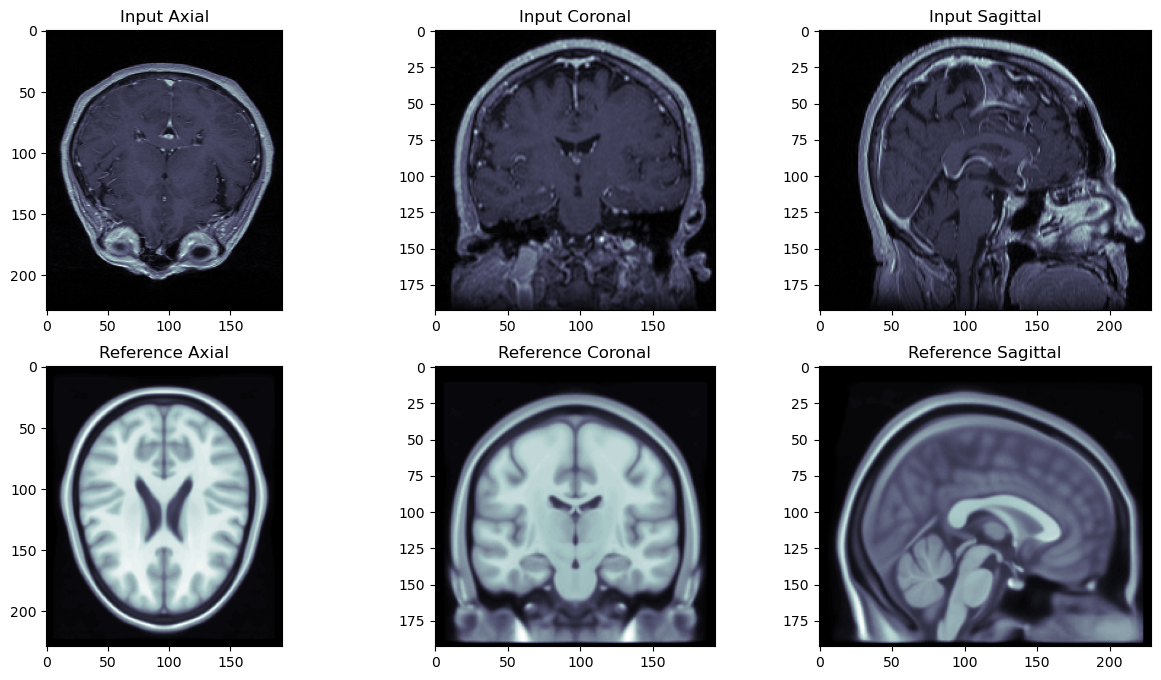

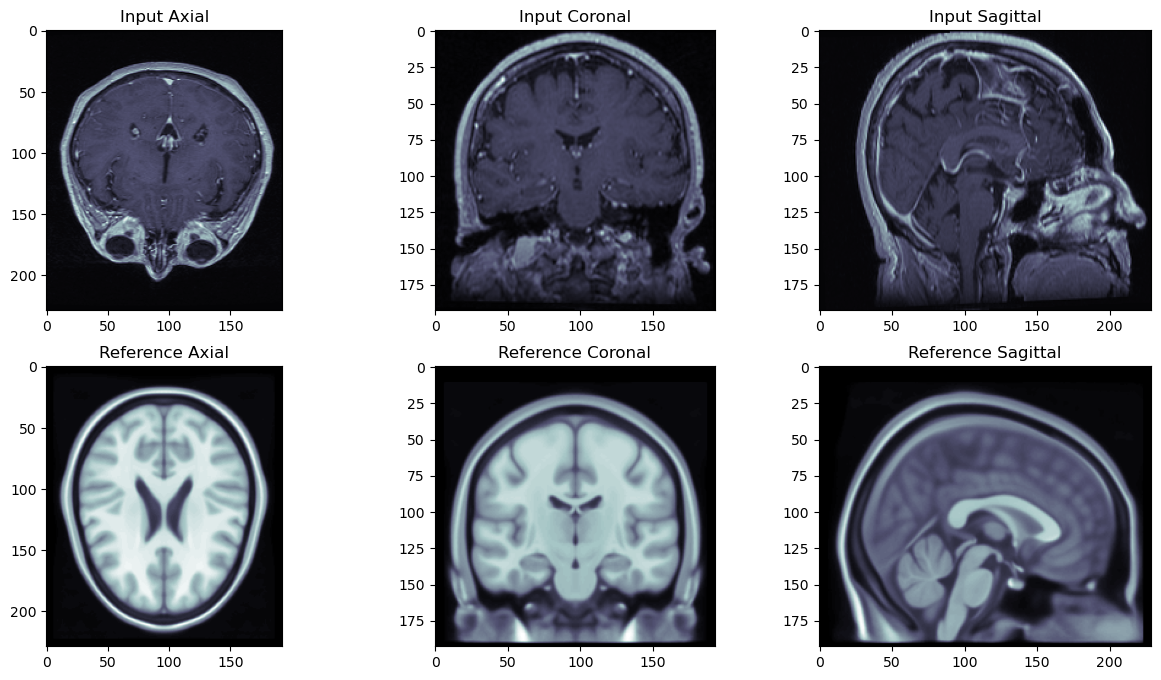

In [54]:
plot_image_and_reference_comparison(norm_input, rotated_ref_block, img_aspect=1.0,
                                    ref_aspect=1.0)
plot_image_and_reference_comparison(final_block_bfgs, rotated_ref_block, img_aspect=1.0,
                                    ref_aspect=1.0)

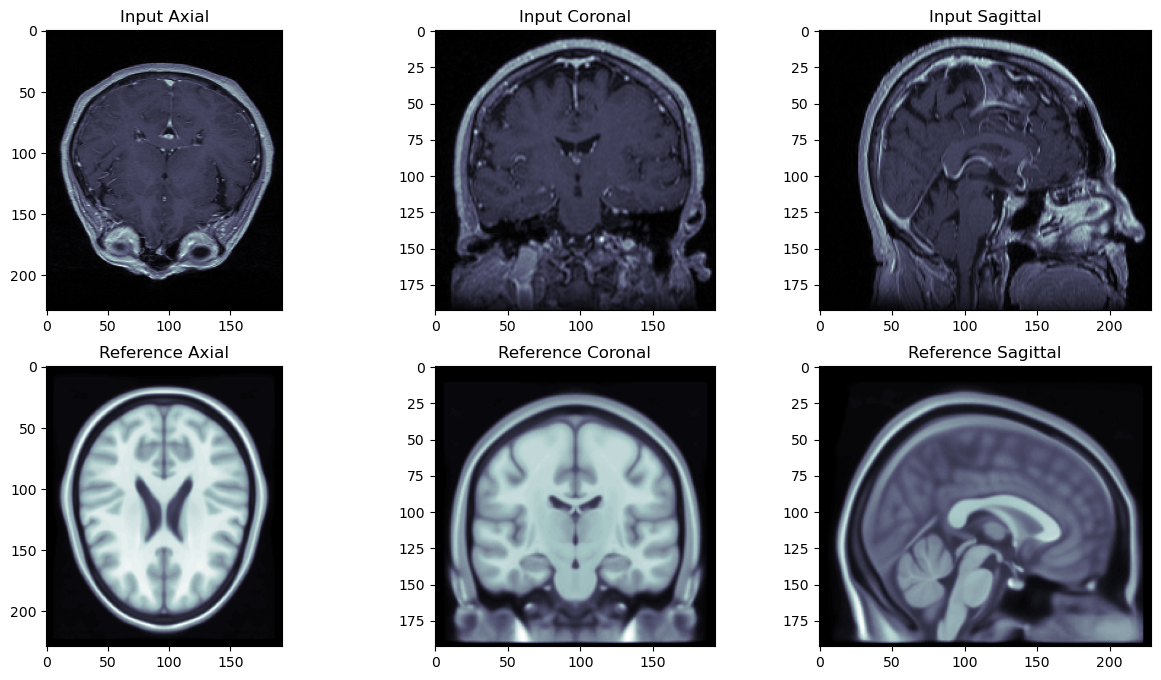

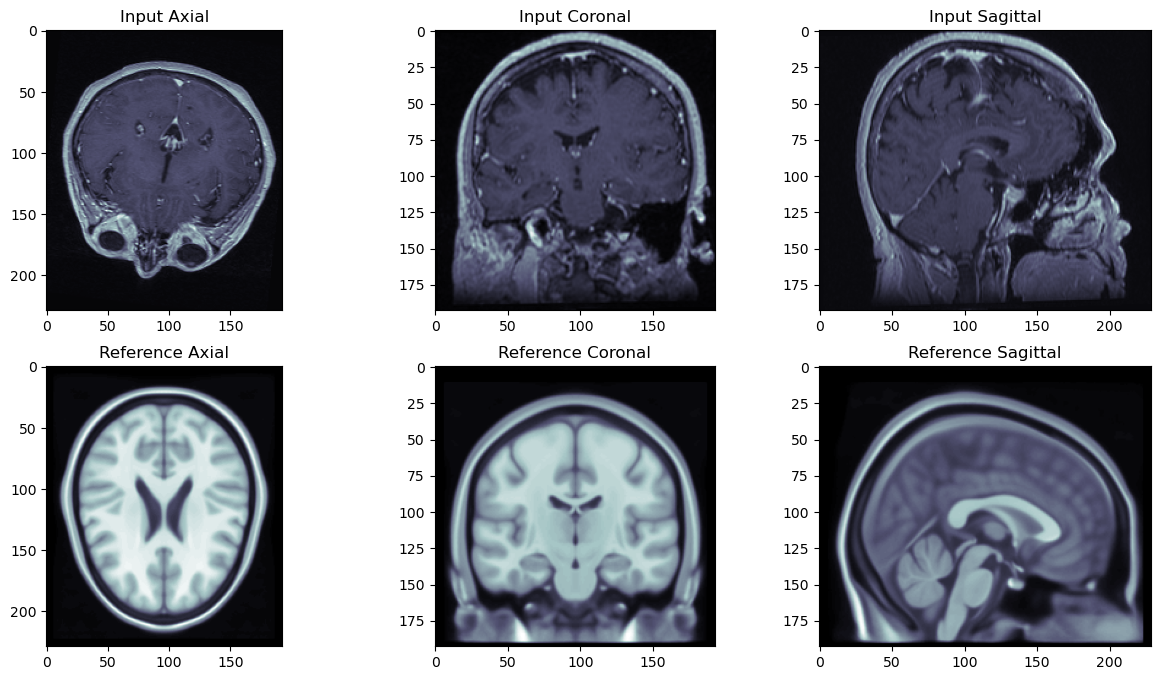

In [55]:
plot_image_and_reference_comparison(norm_input, rotated_ref_block, img_aspect=1.0,
                                    ref_aspect=1.0)
plot_image_and_reference_comparison(final_block_le, rotated_ref_block, img_aspect=1.0,
                                    ref_aspect=1.0)

In [57]:
print('start to final error bfgs: ', errors_bfgs[0], errors_bfgs[-1])
print('result bfgs: ', result_bfgs.x)
print('start to final error le: ', errors_le[0], errors_le[-1])
print('result le: ', result_le.x)



start to final error bfgs:  0.05349500479506326 0.05332436353528487
result bfgs:  [-5.43041536e+00 -1.65817028e+00  6.41275846e-04  9.53922389e-03
 -1.48584686e-02  4.39055935e-02]
start to final error le:  0.05352649218383825 0.05323401475490269
result le:  [-5.43041536e+00 -1.65817028e+00  6.41275846e-04 -1.07440614e-01
  1.77594146e-02  3.27990211e-02]


# Task 2

In [58]:
atlas_path = "./p2data/AAL3_1mm.dcm"
atlas_segment = dicom.dcmread(atlas_path)
atlas_block = atlas_segment.pixel_array

In [59]:
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    # Your code here:
    #   ...
    """
    81 Thalamus_L 
    82 Thalamus_R 
    :param img_atlas: 
    :return: 
    """
    mask = np.zeros_like(img_atlas)
    for i in range (121, 151):
        mask[img_atlas == i] = 1
    return mask


/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_81237/3407081122.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


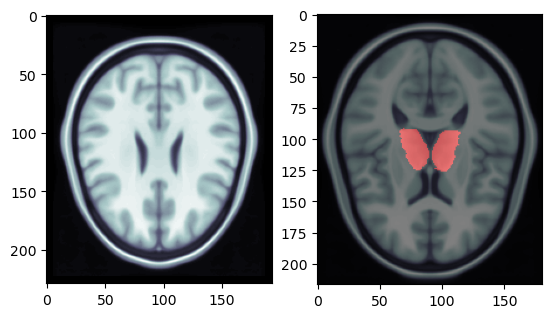

getting volume 
Thalamus volume:
  >> Result: 16699 mm^3
Thalamus surface:
  >> Result: 7106.0 mm^2


In [60]:
atlas_path = "./p2data/AAL3_1mm.dcm"
atlas_segment = dicom.dcmread(atlas_path)
atlas_block = atlas_segment.pixel_array
thalamus_mask = get_thalamus_mask(atlas_block)
img_phantom = ref_block[6:-6, 6:-6, 6:-6]     # Crop phantom to atlas size
thalamus_mask_centroid = find_centroid(thalamus_mask)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(ref_block[100, :, :], cmap='bone')
axs[1].imshow(img_phantom[100, :, :], cmap='tab20')
fig.show()

visualize_axial_slice(img_phantom, thalamus_mask, thalamus_mask_centroid)
print('getting volume ')

vol = find_region_volume(thalamus_mask)
surf = find_region_surface(thalamus_mask)

print('Thalamus volume:')
print(f'  >> Result: {vol} mm^3')

print('Thalamus surface:')
print(f'  >> Result: {surf} mm^2')

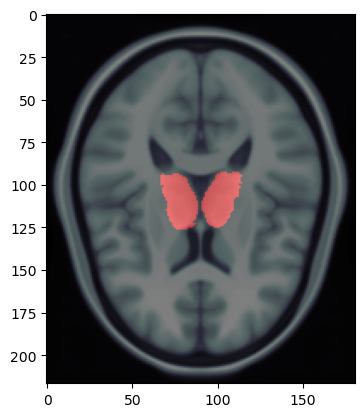

In [61]:
# rotate phantom and segmentation for better viewing 
rotated_img_phantom = scipy.ndimage.rotate(img_phantom.copy(), 180, axes=(0, 2), reshape=False, mode='nearest', order=0)
rotated_thalamus_mask = scipy.ndimage.rotate(thalamus_mask, 180, axes=(0, 2), reshape=False, mode='nearest', order=0)
rotated_thalamus_mask_centroid = find_centroid(rotated_thalamus_mask)
visualize_axial_slice(rotated_img_phantom, rotated_thalamus_mask, rotated_thalamus_mask_centroid)


In [68]:
def inverse_transform_block(params, original_block):
    """
    Apply translation and rotation to the reference block.
    params: [trans_x, trans_y, trans_z, angle_x, angle_y, angle_z]
    reference_block: 3D numpy array (the reference image block)
    """
    trans_x, trans_y, trans_z, angle_x, angle_y, angle_z = params


    # Apply rotation
    rotated = original_block.copy()
    rotated = scipy.ndimage.rotate(rotated, to_degree(angle_x), axes=(1, 2), reshape=False)
    rotated = scipy.ndimage.rotate(rotated, to_degree(angle_y), axes=(0, 2), reshape=False)
    rotated = scipy.ndimage.rotate(rotated, to_degree(angle_z), axes=(0, 1), reshape=False)
    
    
    
    

    # Apply translation
    translated = np.roll(rotated, np.array(params[:3]).astype(int), axis=(0, 1, 2))

    return translated

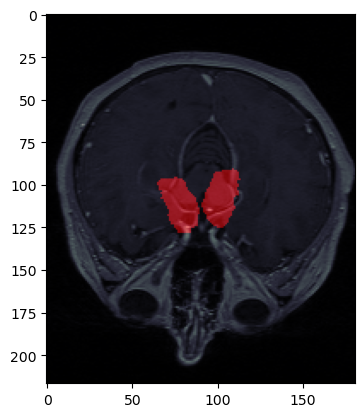

In [74]:
thalamus_transformed_mask = inverse_transform_block(-1*result_le.x, rotated_thalamus_mask.copy())
mask_centroid = find_centroid(thalamus_transformed_mask)
visualize_axial_slice(rotated_zoomed_input[6:-6, 6:-6, 6:-6], thalamus_transformed_mask, mask_centroid)

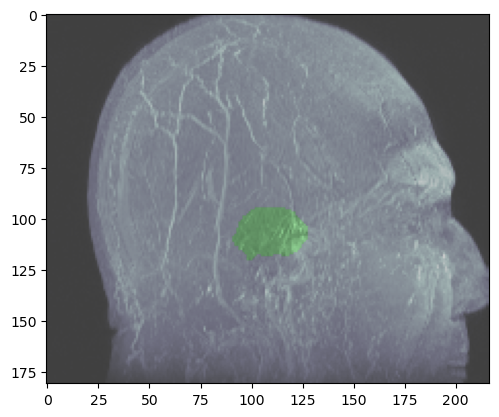

In [75]:
def axial_rotate_and_mip_projection(img, angle):
    return MIP_sagittal_plane(rotate_on_axial_plane(img, angle))

frames_per_full_rotation = 80
patient_block = rotated_zoomed_input[6:-6, 6:-6, 6:-6]
angles = np.linspace(0, 360*(frames_per_full_rotation-1)/frames_per_full_rotation, num=frames_per_full_rotation)
fused_images_for_animation = []
for idx, angle in enumerate(angles):
    sagittal_seg = axial_rotate_and_mip_projection(thalamus_transformed_mask, angle)
    sagittal_ct = axial_rotate_and_mip_projection(patient_block, angle)
    fused_img = visualize_alpha_fusion(sagittal_ct, sagittal_seg, visualize=False)
    fused_images_for_animation.append(fused_img)

fig, ax = plt.subplots()
cm = matplotlib.colormaps.get_cmap('bone')
pixel_len_mm = [float(input_dcms[0].SliceThickness),
                input_dcms[0].PixelSpacing[0],
                input_dcms[0].PixelSpacing[1]]
aspect_ratio = pixel_len_mm[0] / pixel_len_mm[1]
animation_data = [
    [
        plt.imshow(img,
                   animated=True,
                   vmin=np.amin(patient_block),
                   vmax=np.amax(patient_block),
                   cmap=cm, aspect=1)
    ]
    for img in fused_images_for_animation
]
all_seg_rot_gif = animation.ArtistAnimation(fig, animation_data, interval=120, blit=True)
all_seg_rot_gif.save("thamalus_changed.gif")